## Load documents with IDs

In [1]:
import requests
import pandas as pd

url_prefix = 'https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/03-evaluation/'
docs_url = url_prefix + 'search_evaluation/documents-with-ids.json'
documents = requests.get(docs_url).json()

ground_truth_url = url_prefix + 'search_evaluation/ground-truth-data.csv'
df_ground_truth = pd.read_csv(ground_truth_url)
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')

In [2]:
documents[10]

{'text': 'It depends on your background and previous experience with modules. It is expected to require about 5 - 15 hours per week. [source1] [source2]\nYou can also calculate it yourself using this data and then update this answer.',
 'section': 'General course-related questions',
 'question': 'Course - \u200b\u200bHow many hours per week am I expected to spend on this  course?',
 'course': 'data-engineering-zoomcamp',
 'id': 'ea739c65'}

In [3]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [4]:
doc_idx = {d['id']: d for d in documents}
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

## Index data

We'll generate embeddings using [the sentence transformers](https://sbert.net/) library, if you don't have it, install it with pip:

```bash
pip install sentence-transformers
```

This is a different way of turning sentences into vectors

In [9]:
from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

d:\ai\llm-zoomcamp\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\ai\llm-zoomcamp\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\51942\.cache\huggingface\hub\models--sentence-transformers--multi-qa-MiniLM-L6-cos-v1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate 

In [10]:
from tqdm.auto import tqdm

vectors = []

for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    vector = model.encode(question + ' ' + text)
    vectors.append(vector)

  0%|          | 0/948 [00:00<?, ?it/s]

100%|██████████| 948/948 [01:01<00:00, 15.39it/s]


In [11]:
import numpy as np

vectors = np.array(vectors)

In [14]:
from minsearch import VectorSearch

vindex = VectorSearch(keyword_fields=['course'])
vindex.fit(vectors, documents)

## Retrieval

In [12]:
def minsearch_vector_search(vector, course):
    return vindex.search(
        vector,
        filter_dict={'course': course},
        num_results=5
    )

def question_text_vector(q):
    question = q['question']
    course = q['course']

    v_q = model.encode(question)

    return minsearch_vector_search(v_q, course)

In [15]:
question_text_vector(dict(
    question='Are sessions recorded if I miss one?',
    course='machine-learning-zoomcamp'
))

[{'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'section': 'General course-related questions',
  'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'id': '5170565b'},
 {'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'section': 'General course-related questions',
  'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'id': '39fda9f0'},
 {'text': "Problem description\nThe accuracy and the loss are both still the same or nearly the same while training.\nSol

## The RAG flow

In [18]:
from dotenv import load_dotenv
from datetime import datetime
from langchain_openai import AzureChatOpenAI
from langchain.schema.messages import HumanMessage
from langchain.prompts import ChatPromptTemplate
import json
import requests
load_dotenv()

True

In [16]:
def generate_prompt(question: str, search_results: list[str]):
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system", """
                You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
                Use only the facts from the CONTEXT when answering the QUESTION.

                CONTEXT: {context}"""
            ),
            ("human", "{query}"),
            ("placeholder", "{agent_scratchpad}"),
            ]
        )
    context = ''
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    return prompt.format_messages(query=question, context=context, current_date=datetime.now().strftime("%Y-%m-%d %H:%M:%S"))


In [19]:
def get_llm_client() -> AzureChatOpenAI:
    return AzureChatOpenAI(
        deployment_name="gpt-4o-mini",
        model_name='gpt-4o-mini',
        )

In [20]:
def llm_execute(llm_client: AzureChatOpenAI, prompt: list[str]) -> str:
    response = llm_client.invoke(prompt)
    return response.content

In [21]:
def rag(llm_client: AzureChatOpenAI, query: dict) -> str:
    search_results = question_text_vector(query)
    prompt = generate_prompt(query, search_results)
    answer = llm_execute(llm_client, prompt)
    return answer

In [24]:
llm_client = get_llm_client()

In [22]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [25]:
rag(llm_client, ground_truth[10])

'Yes, everything is recorded, so you won’t miss anything. You will still be able to ask your questions for office hours in advance, and they will be covered during the live stream. Additionally, you can always ask questions in Slack.'

In [26]:
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

## Cosine similarity metric

In [27]:
answer_orig = 'Yes, everything is recorded, so you won’t miss anything. You will still be able to ask your questions for office hours in advance, and they will be covered during the live stream. Additionally, you can always ask questions in Slack.'
answer_llm = 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

v_llm = model.encode(answer_llm)
v_orig = model.encode(answer_orig)

v_llm.dot(v_orig)

np.float32(0.94774884)

In [18]:
ground_truth[0]

{'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp',
 'document': '0227b872'}

In [19]:
len(ground_truth)

1830

In [65]:
rec

{'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp',
 'document': '0227b872'}

In [ ]:
answers = {}

In [89]:
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue

    answer_llm = rag(rec)
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

  0%|          | 0/1830 [00:00<?, ?it/s]

In [107]:
results_gpt4o = [None] * len(ground_truth)

for i, val in answers.items():
    results_gpt4o[i] = val.copy()
    results_gpt4o[i].update(ground_truth[i])

In [95]:
import pandas as pd

In [110]:
df_gpt4o = pd.DataFrame(results_gpt4o)

In [112]:
!mkdir data

In [113]:
df_gpt4o.to_csv('data/results-gpt4o.csv', index=False)

## Evaluating GPT 3.5

In [119]:
rag(ground_truth[10], model='gpt-3.5-turbo')

"No, sessions are recorded so if you miss one, you won't miss anything."

In [120]:
from tqdm.auto import tqdm

from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=6)

def map_progress(pool, seq, f):
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results

In [121]:
def process_record(rec):
    model = 'gpt-3.5-turbo'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [122]:
process_record(ground_truth[10])

{'answer_llm': 'Yes, sessions are recorded if you miss one. Everything is recorded, so you won’t miss anything, and you can also ask questions for office hours in advance which will be covered during the live stream. You can always ask questions in Slack as well.',
 'answer_orig': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'document': '5170565b',
 'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp'}

In [123]:
results_gpt35 = map_progress(pool, ground_truth, process_record)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [29]:
df_gpt35 = pd.DataFrame(results_gpt35)
df_gpt35.to_csv('data/results-gpt35.csv', index=False)

NameError: name 'results_gpt35' is not defined

In [125]:
!head data/results-gpt35.csv

answer_llm,answer_orig,document,question,course
You can sign up for the course by going to the course page at http://mlzoomcamp.com/ and scrolling down to access the course materials.,"Machine Learning Zoomcamp FAQ
The purpose of this document is to capture frequently asked technical questions.
We did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:
Data Engineering Zoomcamp FAQ
In the course GitHub repository thereâ€™s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo
work",0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
"I am sorry, but there is no direct link provided in the FAQ database for signing up for the course. However, you can find a link in the course GitHub repository at this address: https://airtable.com/shryxwLd0COOEaqXo.","Machine Learning Zoomcamp FAQ
The purpose of this document is to capture frequently asked technical questions.
We did thi

## Cosine similarity

A->Q->A' cosine similarity

A -> Q -> A'

cosine(A, A')

### gpt-4o

In [30]:
df_gpt4o = pd.read_csv('data/results-gpt4o.csv')
results_gpt4o = df_gpt4o.to_dict(orient='records')

In [31]:
record = results_gpt4o[0]

In [33]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [35]:
similarity = []

for record in tqdm(results_gpt4o):
    sim = compute_similarity(record)
    similarity.append(sim)

100%|██████████| 1830/1830 [03:19<00:00,  9.18it/s]


In [36]:
df_gpt4o['cosine'] = similarity
df_gpt4o['cosine'].describe()

count    1830.000000
mean        0.679129
std         0.217995
min        -0.153425
25%         0.591460
50%         0.734788
75%         0.835390
max         0.995338
Name: cosine, dtype: float64

In [37]:
import seaborn as sns

### gpt-3.5-turbo

In [38]:
df_gpt35 = pd.read_csv('data/results-gpt35.csv')
results_gpt35 = df_gpt35.to_dict(orient='records')

similarity_35 = []

for record in tqdm(results_gpt35):
    sim = compute_similarity(record)
    similarity_35.append(sim)

100%|██████████| 1830/1830 [02:18<00:00, 13.24it/s]


In [39]:
df_gpt35['cosine'] = similarity_35
df_gpt35['cosine'].describe()

count    1830.000000
mean        0.657599
std         0.226062
min        -0.168921
25%         0.546504
50%         0.714783
75%         0.817262
max         1.000000
Name: cosine, dtype: float64

In [40]:
import matplotlib.pyplot as plt

C:\Users\51942\AppData\Local\Temp\ipykernel_20160\2818767811.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['cosine'], label='4o')
C:\Users\51942\AppData\Local\Temp\ipykernel_20160\2818767811.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt35['cosine'], label='3.5')


<Axes: xlabel='cosine', ylabel='Density'>

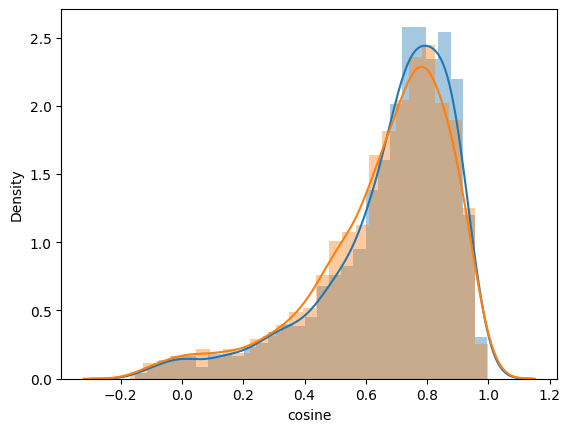

In [41]:
sns.distplot(df_gpt4o['cosine'], label='4o')
sns.distplot(df_gpt35['cosine'], label='3.5')
# sns.distplot(df_gpt4o_mini['cosine'], label='4o-mini')

### gpt-4o-mini

In [151]:
def process_record_4o_mini(rec):
    model = 'gpt-4o-mini'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [152]:
process_record_4o_mini(ground_truth[10])

{'answer_llm': "Yes, sessions are recorded, so if you miss one, you won't miss anything. You can catch up by watching the recorded sessions later. Additionally, you have the option to ask questions in advance for office hours, which will also be recorded.",
 'answer_orig': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'document': '5170565b',
 'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp'}

In [ ]:
results_gpt4omini = []

In [157]:
for record in tqdm(ground_truth):
    result = process_record_4o_mini(record)
    results_gpt4omini.append(result)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [ ]:
df_gpt4o_mini = pd.DataFrame(results_gpt4omini)
df_gpt4o_mini.to_csv('data/results-gpt4o-mini.csv', index=False)

In [42]:
df_gpt4o_mini = pd.read_csv('data/results-gpt4o-mini.csv')
results_gpt4omini = df_gpt4o_mini.to_dict(orient='records')
similarity_4o_mini = []

for record in tqdm(results_gpt4omini):
    sim = compute_similarity(record)
    similarity_4o_mini.append(sim)

100%|██████████| 1830/1830 [03:16<00:00,  9.33it/s]


In [43]:
df_gpt4o_mini['cosine'] = similarity_4o_mini
df_gpt4o_mini['cosine'].describe()

count    1830.000000
mean        0.680332
std         0.215962
min        -0.141910
25%         0.585866
50%         0.733998
75%         0.836750
max         0.982701
Name: cosine, dtype: float64

gpt4o 

```
count    1830.000000
mean        0.679129
std         0.217995
min        -0.153426
25%         0.591460
50%         0.734788
75%         0.835390
max         0.995339
Name: cosine, dtype: float64
```

C:\Users\51942\AppData\Local\Temp\ipykernel_20160\4043211035.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['cosine'], label='4o')
C:\Users\51942\AppData\Local\Temp\ipykernel_20160\4043211035.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o_mini['cosine'], label='4o-min

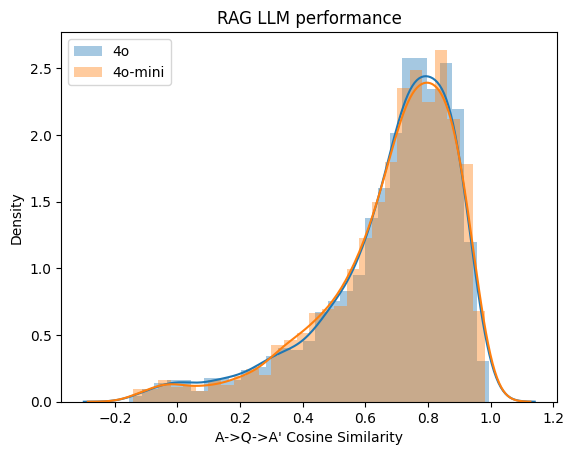

In [44]:
# sns.distplot(df_gpt35['cosine'], label='3.5')

sns.distplot(df_gpt4o['cosine'], label='4o')
sns.distplot(df_gpt4o_mini['cosine'], label='4o-mini')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

## LLM-as-a-Judge

In [45]:
from langchain.prompts import ChatPromptTemplate

In [46]:
prompt_template_1 = ChatPromptTemplate.from_messages(
    [
        ("system", """
            You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
            Your task is to analyze the relevance of the generated answer compared to the original answer provided.
            Based on the relevance and similarity of the generated answer to the original answer, you will classify
            it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

            Here is the data for evaluation:

            Original Answer: {answer_orig}
            Generated Question: {question}
            Generated Answer: {answer_llm}

            Please analyze the content and context of the generated answer in relation to the original
            answer and provide your evaluation in parsable JSON without using code blocks:

            {{
            "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
            "Explanation": "[Provide a brief explanation for your evaluation]"
            }}
            """)
    ]
)

In [47]:
prompt_template_2 = ChatPromptTemplate.from_messages(
    [
        ("system", """
            You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
            Your task is to analyze the relevance of the generated answer to the given question.
            Based on the relevance of the generated answer, you will classify it
            as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

            Here is the data for evaluation:

            Question: {question}
            Generated Answer: {answer_llm}

            Please analyze the content and context of the generated answer in relation to the question
            and provide your evaluation in parsable JSON without using code blocks:

            {{
            "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
            "Explanation": "[Provide a brief explanation for your evaluation]"
            }}
            """)
    ]
)

In [48]:
df_sample = df_gpt4o_mini.sample(n=150, random_state=1)

In [49]:
samples = df_sample.to_dict(orient='records')

In [50]:
record = samples[0]
record

{'answer_llm': 'The syntax for using `precision_recall_fscore_support` in Python is as follows:\r\n\r\n```python\r\nfrom sklearn.metrics import precision_recall_fscore_support\r\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\r\n```',
 'answer_orig': 'Scikit-learn offers another way: precision_recall_fscore_support\r\nExample:\r\nfrom sklearn.metrics import precision_recall_fscore_support\r\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\r\n(Gopakumar Gopinathan)',
 'document': '403bbdd8',
 'question': 'What is the syntax for using precision_recall_fscore_support in Python?',
 'course': 'machine-learning-zoomcamp',
 'cosine': 0.901075541973114}

In [55]:
prompt = prompt_template_1.format_messages(**record)
print(prompt[0].content)


            You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
            Your task is to analyze the relevance of the generated answer compared to the original answer provided.
            Based on the relevance and similarity of the generated answer to the original answer, you will classify
            it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

            Here is the data for evaluation:

            Original Answer: Scikit-learn offers another way: precision_recall_fscore_support
Example:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)
(Gopakumar Gopinathan)
            Generated Question: What is the syntax for using precision_recall_fscore_support in Python?
            Generated Answer: The syntax for using `precision_recall_fscore_support` in Python is as follows:

```python
from sklearn.metrics import precision_recall_

In [56]:
answer = llm_client.invoke(prompt)

In [62]:
json.loads(answer.content)

{'Relevance': 'RELEVANT',
 'Explanation': 'The generated answer provides the exact syntax for using `precision_recall_fscore_support` in Python, which is the same information contained in the original answer. It directly addresses the question about syntax, demonstrating a complete alignment with the original content.'}

In [58]:
import json

In [65]:
evaluations = []

for record in tqdm(samples):
    prompt = prompt_template_1.format(**record)
    evaluation = llm_client.invoke(prompt)
    evaluations.append(evaluation.content)

100%|██████████| 150/150 [02:31<00:00,  1.01s/it]


In [66]:
json_evaluations = []

for i, str_eval in enumerate(evaluations):
    json_eval = json.loads(str_eval)
    json_evaluations.append(json_eval)

In [67]:
df_evaluations = pd.DataFrame(json_evaluations)

In [68]:
df_evaluations.Relevance.value_counts()

Relevance
RELEVANT           123
PARTLY_RELEVANT     16
NON_RELEVANT        11
Name: count, dtype: int64

In [71]:
df_evaluations[df_evaluations.Relevance == 'NON_RELEVANT'].to_dict(orient='records')

[{'Relevance': 'NON_RELEVANT',
  'Explanation': 'The generated answer focuses on a different topic (version conflict in Scikit-Learn) than the original answer, which pertains to a specific error encountered during a Docker build related to Python wheel versions. There is no overlap in content or context between the two responses.'},
 {'Relevance': 'NON_RELEVANT',
  'Explanation': "The generated answer addresses a different problem related to the protobuf package rather than the NotSupportedError specific to 'eb local' command usage with Docker platforms mentioned in the original answer. It does not provide relevant steps for resolving the original error described."},
 {'Relevance': 'NON_RELEVANT',
  'Explanation': 'The generated answer incorrectly states that the context does not provide an alternative command when the region is configured by default. In fact, the original answer explicitly provides the alternative command for that scenario, making the generated response inaccurate and

In [70]:
samples[4]

{'answer_llm': "The cause of the pip version error in this week's serverless deep learning section could be a version conflict in Scikit-Learn. Specifically, if you are using a different version than what was used during the model training, it can lead to warnings and potential breaking code or invalid results. To resolve this, make sure to use the same version of Scikit-Learn that was used for training the model. For instance, if you trained with version 1.1.1, you should use that same version in your virtual environment.",
 'answer_orig': 'When running docker build -t dino-dragon-model it returns the above error\r\nThe most common source of this error in this week is because Alex video shows a version of the wheel with python 8, we need to find a wheel with the version that we are working on. In this case python 9. Another common error is to copy the link, this will also produce the same error, we need to download the raw format:\r\nhttps://github.com/alexeygrigorev/tflite-aws-lambda

In [72]:
prompt = prompt_template_2.format(**record)
print(prompt)

System: 
            You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
            Your task is to analyze the relevance of the generated answer to the given question.
            Based on the relevance of the generated answer, you will classify it
            as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

            Here is the data for evaluation:

            Question: What modification was made to the median_house_value target in the homework?
            Generated Answer: The modification made to the `median_house_value` target in the homework was that it was changed to binary format. The values were made discrete as either 0 or 1, instead of remaining as a continuous variable. This change was necessary for the calculation of the mutual information score, which is applicable to categorical or discrete variables rather than continuous ones.

            Please analyze the content and context of the generated answer in relation to the question
  

In [73]:
evaluations_2 = []

for record in tqdm(samples):
    prompt = prompt_template_2.format(**record)
    evaluation = llm_client.invoke(prompt)
    evaluations_2.append(evaluation.content)

100%|██████████| 150/150 [02:21<00:00,  1.06it/s]


In [74]:
json_evaluations_2 = []

for i, str_eval in enumerate(evaluations_2):
    json_eval = json.loads(str_eval)
    json_evaluations_2.append(json_eval)

In [75]:
df_evaluations_2 = pd.DataFrame(json_evaluations_2)

In [76]:
df_evaluations_2[df_evaluations_2.Relevance == 'NON_RELEVANT']

,Relevance,Explanation
45,NON_RELEVANT,The generated answer does not attempt to addre...
102,NON_RELEVANT,The generated answer incorrectly assumes that ...
139,NON_RELEVANT,The generated answer does not address the spec...


In [243]:
samples[45]

{'answer_llm': 'The provided context does not include specific commands to start the Docker daemon on Linux. Therefore, I cannot provide an answer based solely on the facts from the context.',
 'answer_orig': 'Working on getting Docker installed - when I try running hello-world I am getting the error.\nDocker: Cannot connect to the docker daemon at unix:///var/run/docker.sock. Is the Docker daemon running ?\nSolution description\nIf you’re getting this error on WSL, re-install your docker: remove the docker installation from WSL and install Docker Desktop on your host machine (Windows).\nOn Linux, start the docker daemon with either of these commands:\nsudo dockerd\nsudo service docker start\nAdded by Ugochukwu Onyebuchi',
 'document': '4b2a3181',
 'question': 'What commands should I use to start the docker daemon on Linux?',
 'course': 'machine-learning-zoomcamp',
 'cosine': 0.51130211353302}

## Saving all the data

In [244]:
df_gpt4o.to_csv('data/results-gpt4o-cosine.csv', index=False)
df_gpt35.to_csv('data/results-gpt35-cosine.csv', index=False)
df_gpt4o_mini.to_csv('data/results-gpt4o-mini-cosine.csv', index=False)

In [245]:
df_evaluations.to_csv('data/evaluations-aqa.csv', index=False)
df_evaluations_2.to_csv('data/evaluations-qa.csv', index=False)